In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from itertools import cycle

pd.set_option("display.max_rows", 40)
pd.set_option("display.min_rows", 40)

In [2]:
filename = "qPCR_2021-04-28.xlsx"
melt = pd.read_excel(filename, "Melt Curve Raw Data", skiprows=43)
amp = pd.read_excel(filename, "Amplification Data", skiprows=43)

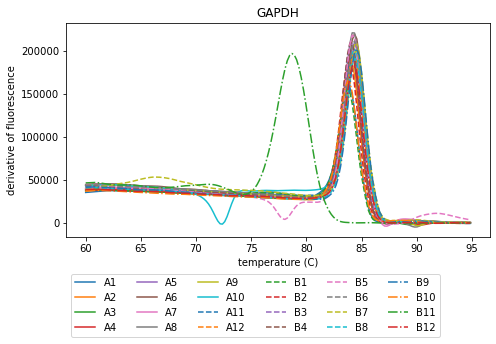

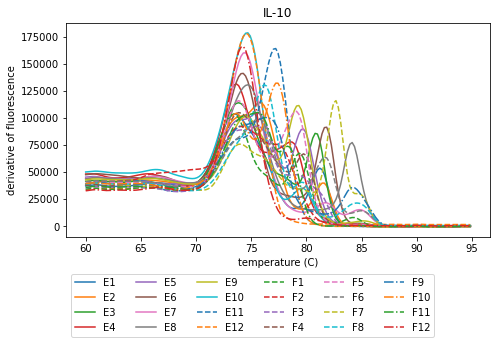

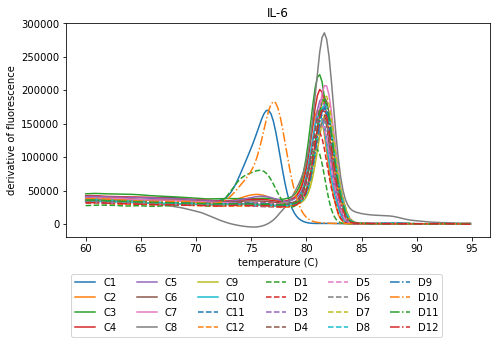

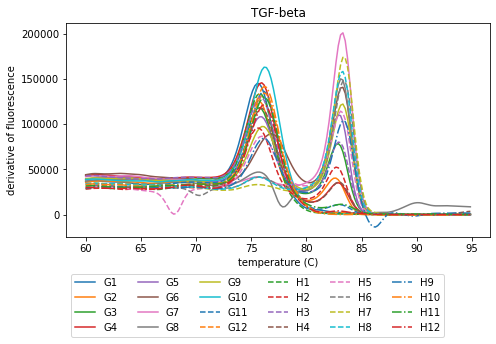

In [3]:
for target, g in melt.groupby("Target Name"):
    plt.figure(f"melt-{target}")
    linecycler = cycle(["-"]*10 + ["--"]*10 + ["-."]*10 + [":"]*10)
    for well, gg in g.groupby("Well Position", sort=False):
        plt.plot(gg["Temperature"], gg["Derivative"], label=well, linestyle=next(linecycler))
    plt.xlabel("temperature (C)")
    plt.ylabel("derivative of fluorescence")
    plt.title(target)
    plt.legend(ncol=6, loc="upper left", bbox_to_anchor=(0, -0.15))
    plt.gcf().set_size_inches(7, 5)
    plt.tight_layout()
    plt.savefig(f"plots/melt_curves_{target}.png", dpi=400)
    plt.show()

In [4]:
conditions = {
    1: "peptide (high)",
    2: "peptide (high)",
    3: "peptide (high) + LPS",
    4: "peptide (high) + LPS",
    5: "peptide (low)",
    6: "peptide-myrs (low)",
    7: "peptide (low) + LPS",
    8: "peptide-myrs (low) + LPS",
    9: "blank",
    10: "peptide-myrs (high)",
    11: "LPS",
    12: "peptide-myrs (high) + LPS"
}

amp["Row"] = [s[0] for s in amp["Well Position"]]
amp["Column"] = [int(s[1:]) for s in amp["Well Position"]]
amp["Condition"] = [conditions[c] for c in amp["Column"]]

In [5]:
# remove data for wells where incorrect PCR product formed (based on melt curve analysis)
discard = {"B11", "C1", "D10"}
amp = amp[~amp["Well Position"].isin(discard)]

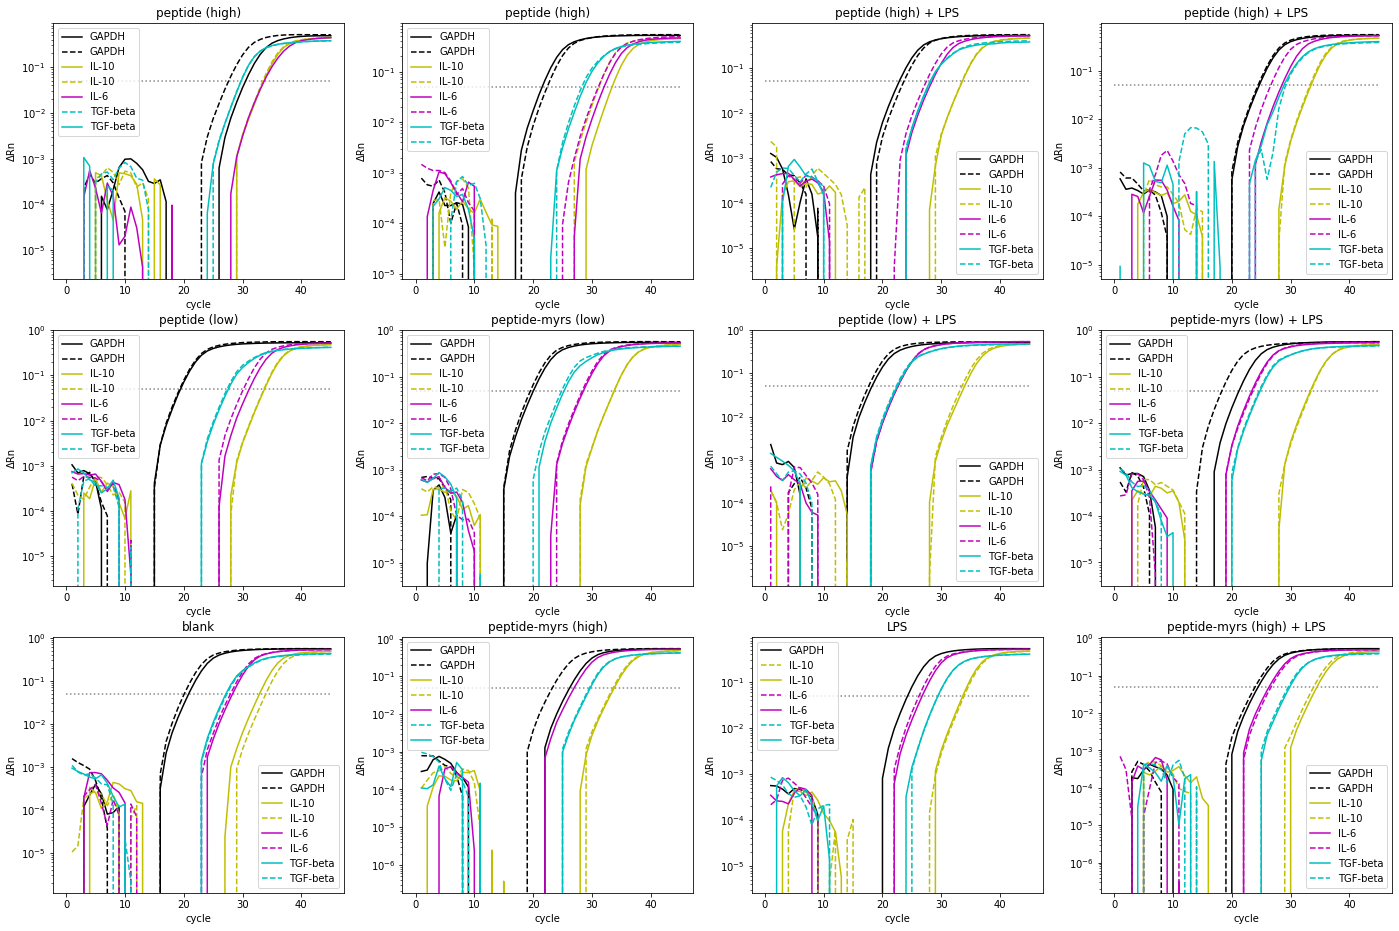

In [11]:
# plot all amplification data
colors = {"GAPDH": "k", "IL-6": "m", "IL-10": "y", "TGF-beta": "c"}

threshold = 0.05
for col, g in amp.groupby("Column"):
    linecycler = cycle(["-", "--"])
    plt.subplot(3, 4, col)
    for target, g2 in g.groupby("Target Name"):
        for row, g3 in g2.groupby("Row"):
            plt.plot(g3["Cycle"], g3["Delta Rn"],
                color=colors[target],
                linestyle=next(linecycler),
                label=target
            )
    plt.hlines(threshold, 0, 45, colors="#888888", linestyles=":")
    plt.xlabel("cycle")
    plt.ylabel("ΔRn")
    plt.legend()
    plt.yscale("log")
    plt.title(conditions[col])
plt.gcf().set_size_inches(24, 16)
plt.show()


In [12]:
# convert amplification data into CT values
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

def get_ct(rxn):
    fun = interp1d(rxn["Cycle"], rxn["Delta Rn"] - threshold, bounds_error=False)
    sol = root_scalar(fun, bracket=(10, 40), x0=25, x1=35)
    return sol.root

rxns = amp.drop(columns=["Cycle", "Rn", "Delta Rn"]).drop_duplicates().set_index("Well")
ct = amp.groupby("Well").apply(get_ct)
ct.rename("CT", inplace=True)
rxns["CT"] = ct
display(rxns)


,Well Position,Target Name,Row,Column,Condition,CT
Well,,,,,,
1,A1,GAPDH,A,1,peptide (high),30.442308
2,A2,GAPDH,A,2,peptide (high),21.466632
3,A3,GAPDH,A,3,peptide (high) + LPS,22.790858
4,A4,GAPDH,A,4,peptide (high) + LPS,24.578624
5,A5,GAPDH,A,5,peptide (low),19.380664
6,A6,GAPDH,A,6,peptide-myrs (low),20.038517
7,A7,GAPDH,A,7,peptide (low) + LPS,18.163486
8,A8,GAPDH,A,8,peptide-myrs (low) + LPS,21.186755
9,A9,GAPDH,A,9,blank,20.802320


In [13]:
# calculate delta CT for each reaction
house = "GAPDH"
def get_dct(cond):
    ct_house = cond.loc[cond["Target Name"] == house]["CT"]
    return pd.DataFrame({
        "dCT": np.mean(ct_house) - cond["CT"]
    })

dct = rxns.groupby("Condition").apply(get_dct)

rxns["dCT"] = dct
display(rxns)


,Well Position,Target Name,Row,Column,Condition,CT,dCT
Well,,,,,,,
1,A1,GAPDH,A,1,peptide (high),30.442308,-4.991819
2,A2,GAPDH,A,2,peptide (high),21.466632,3.983857
3,A3,GAPDH,A,3,peptide (high) + LPS,22.790858,1.034755
4,A4,GAPDH,A,4,peptide (high) + LPS,24.578624,-0.753011
5,A5,GAPDH,A,5,peptide (low),19.380664,-0.067150
6,A6,GAPDH,A,6,peptide-myrs (low),20.038517,-0.283818
7,A7,GAPDH,A,7,peptide (low) + LPS,18.163486,-0.300688
8,A8,GAPDH,A,8,peptide-myrs (low) + LPS,21.186755,-1.459323
9,A9,GAPDH,A,9,blank,20.802320,-0.365159


In [14]:
# calculate double delta CT for each reaction
control = "blank"
def get_ddct(target):
    dct_control = target.loc[target["Condition"] == control]["dCT"]
    return pd.DataFrame({
        "ddCT": target["dCT"] - np.mean(dct_control)
    })

ddct = rxns.groupby("Target Name").apply(get_ddct)

rxns["ddCT"] = ddct
display(rxns)

,Well Position,Target Name,Row,Column,Condition,CT,dCT,ddCT
Well,,,,,,,,
1,A1,GAPDH,A,1,peptide (high),30.442308,-4.991819,-4.991819
2,A2,GAPDH,A,2,peptide (high),21.466632,3.983857,3.983857
3,A3,GAPDH,A,3,peptide (high) + LPS,22.790858,1.034755,1.034755
4,A4,GAPDH,A,4,peptide (high) + LPS,24.578624,-0.753011,-0.753011
5,A5,GAPDH,A,5,peptide (low),19.380664,-0.067150,-0.067150
6,A6,GAPDH,A,6,peptide-myrs (low),20.038517,-0.283818,-0.283818
7,A7,GAPDH,A,7,peptide (low) + LPS,18.163486,-0.300688,-0.300688
8,A8,GAPDH,A,8,peptide-myrs (low) + LPS,21.186755,-1.459323,-1.459323
9,A9,GAPDH,A,9,blank,20.802320,-0.365159,-0.365159


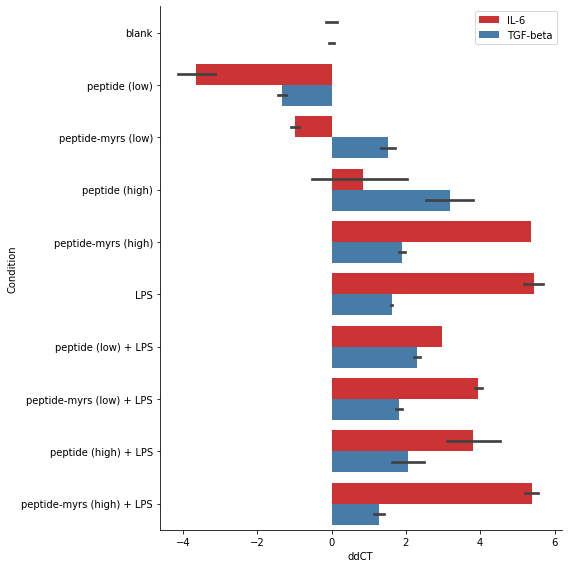

In [15]:
# plot -ddCT (log2 of fold change)
import seaborn as sns

labels = (
    "blank",
    "peptide (low)",
    "peptide-myrs (low)",
    "peptide (high)",
    "peptide-myrs (high)",
    "LPS",
    "peptide (low) + LPS",
    "peptide-myrs (low) + LPS",
    "peptide (high) + LPS",
    "peptide-myrs (high) + LPS",
)
summary = rxns[["Condition", "Target Name", "ddCT"]]
summary = summary[~summary["Target Name"].isin({house, "IL-10"})]
summary["Condition"] = pd.Categorical(summary["Condition"], labels)
summary.sort_values("Condition")

sns.catplot(y="Condition", x="ddCT", hue="Target Name", palette="Set1", orient="h", kind="bar", data=summary, legend=False)
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()